In [1]:
import numpy as np
import pandas as pd
import scipy
import scanpy as sc 
import matplotlib as mpl
from matplotlib import pyplot as plt
# import seaborn as sns
import scrublet as scr
# import harmonypy as hm

In [2]:
import os

# set a working directory for saving plots
wdir = "."
os.chdir( wdir )

# 0 Load raw genex data

In [3]:
adata = sc.read_10x_h5('/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/BL41-42_with_10X/1.3M_brain_11_51/aggr_10x/outs/filtered_feature_bc_matrix.h5')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
assert adata.X.shape == (33145, 31055)

### Annotate cells

In [7]:
# Initalize 'library_name' and 'batch' columns with empty strings
adata.obs['library_name'] = [''] * adata.X.shape[0]
adata.obs['batch'] = [''] * adata.X.shape[0]

In [8]:
# If cell index ends with '1', it's from library BL41, and therefore will be labeled 'BL41_reprogarmmed'; so on and so forth
# Cells from BL41 and BL42 are labeled as batch 'experiment', while cells the public 10X 1.3M brain cell dataset are labeled '10X"
for cell_index in adata.obs.index:
    if cell_index.split('-')[-1] == '1':
        adata.obs['library_name'][cell_index] = 'BL41_reprogrammed'
        adata.obs['batch'][cell_index] = 'experiment'
    elif cell_index.split('-')[-1] == '2':
        adata.obs['library_name'][cell_index] = 'BL42_control'
        adata.obs['batch'][cell_index] = 'experiment'
    elif cell_index.split('-')[-1] == '3':
        adata.obs['library_name'][cell_index] = '10X_sample11'
        adata.obs['batch'][cell_index] = '10X'
    else: 
        adata.obs['library_name'][cell_index] = '10X_sample51'
        adata.obs['batch'][cell_index] = '10X'

In [9]:
# BL41 has 6452 cells, BL42 has 5075 cells
adata.obs['library_name'].value_counts()

10X_sample11         11127
10X_sample51         10491
BL41_reprogrammed     6452
BL42_control          5075
Name: library_name, dtype: int64

### Subset dataset based on library

In [10]:
adata_10X_sample11 = adata[adata.obs['library_name']=='10X_sample11']

In [11]:
adata_10X_sample11.shape

(11127, 31055)

In [12]:
adata_10X_sample51 = adata[adata.obs['library_name']=='10X_sample51']

In [13]:
adata_10X_sample51.shape

(10491, 31055)

In [14]:
adata_BL41 = adata[adata.obs['library_name']=='BL41_reprogrammed']

In [15]:
adata_BL41.shape

(6452, 31055)

In [17]:
adata_BL42 = adata[adata.obs['library_name']=='BL42_control']

In [18]:
adata_BL42.shape

(5075, 31055)

In [20]:
# Double check that the data is raw read counts, not normalized in any way
adata_BL42.X[:10,:10].toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 3.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

# 1 Run Scrublet on each library separately and export results

### Run Scrublet

#### 10X sample 11

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 4.1%
Estimated detectable doublet fraction = 30.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.4%
Elapsed time: 12.3 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

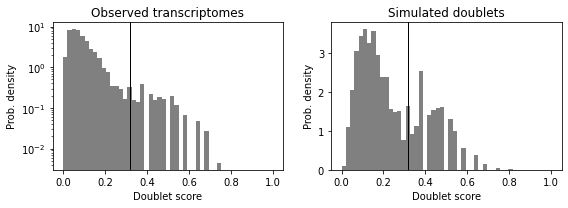

In [37]:
# 10X sample 11
scrub = scr.Scrublet(adata_10X_sample11.X)

doublet_scores, predicted_doublets = scrub.scrub_doublets(synthetic_doublet_umi_subsampling=1, n_prin_comps=30, log_transform=False)

# Mine
scrub.plot_histogram()

In [39]:
adata_10X_sample11.obs['doublet_scores'] = doublet_scores
adata_10X_sample11.obs['predicted_doublets'] = predicted_doublets

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [40]:
adata_10X_sample11.obs.head()

,library_name,batch,doublet_scores,predicted_doublets
AAACCTGAGACTGTAA-3,10X_sample11,10X,0.320000,True
AAACCTGAGCCCAGCT-3,10X_sample11,10X,0.104306,False
AAACCTGAGCGAGAAA-3,10X_sample11,10X,0.047323,False
AAACCTGAGCTAGTTC-3,10X_sample11,10X,0.152416,False
AAACCTGAGGCTAGAC-3,10X_sample11,10X,0.044056,False


In [41]:
adata_10X_sample11.obs['predicted_doublets'].sum()

458

#### 10X sample 51

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 2.9%
Estimated detectable doublet fraction = 26.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.9%
Elapsed time: 12.1 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

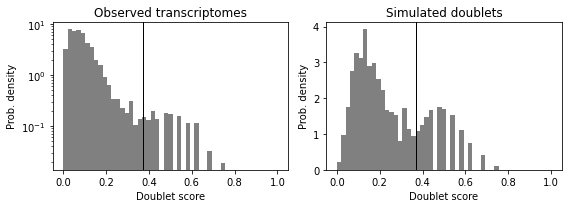

In [42]:
# 10X sample 51
scrub = scr.Scrublet(adata_10X_sample51.X)

doublet_scores, predicted_doublets = scrub.scrub_doublets(synthetic_doublet_umi_subsampling=1, n_prin_comps=30, log_transform=False)

# Mine
scrub.plot_histogram()

In [43]:
sum(predicted_doublets)

301

In [44]:
adata_10X_sample51.obs['doublet_scores'] = doublet_scores
adata_10X_sample51.obs['predicted_doublets'] = predicted_doublets

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [45]:
adata_10X_sample51.obs.head()

,library_name,batch,doublet_scores,predicted_doublets
AAACCTGAGCTAACTC-4,10X_sample51,10X,0.107287,False
AAACCTGAGGATGGAA-4,10X_sample51,10X,0.015371,False
AAACCTGAGTTGTAGA-4,10X_sample51,10X,0.208469,False
AAACCTGCAATCTGCA-4,10X_sample51,10X,0.042672,False
AAACCTGCAATTCCTT-4,10X_sample51,10X,0.038576,False


In [46]:
adata_10X_sample51.obs['predicted_doublets'].sum()

301

#### BL41 - reprogrammed

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 40.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.8%
Elapsed time: 7.1 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

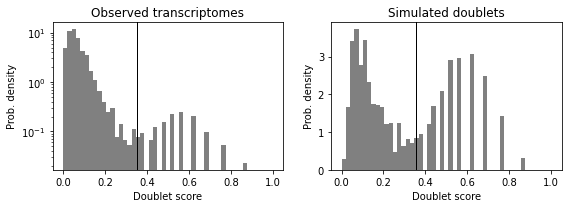

In [47]:
# BL41 - reprogrammed
scrub = scr.Scrublet(adata_BL41.X)

doublet_scores, predicted_doublets = scrub.scrub_doublets(synthetic_doublet_umi_subsampling=1, n_prin_comps=30, log_transform=False)

# Mine
scrub.plot_histogram()

In [48]:
sum(predicted_doublets)

179

In [49]:
adata_BL41.obs['doublet_scores'] = doublet_scores
adata_BL41.obs['predicted_doublets'] = predicted_doublets

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [50]:
adata_BL41.obs.head()

,library_name,batch,doublet_scores,predicted_doublets
AAACCCAAGAACGCGT-1,BL41_reprogrammed,experiment,0.117166,False
AAACCCAAGACTACGG-1,BL41_reprogrammed,experiment,0.021014,False
AAACCCACACAGGATG-1,BL41_reprogrammed,experiment,0.033644,False
AAACCCAGTTGGTGTT-1,BL41_reprogrammed,experiment,0.040927,False
AAACCCATCCCACAGG-1,BL41_reprogrammed,experiment,0.020183,False


In [51]:
adata_BL41.obs['predicted_doublets'].sum()

179

#### BL42 - control

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 33.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.4%
Elapsed time: 5.4 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

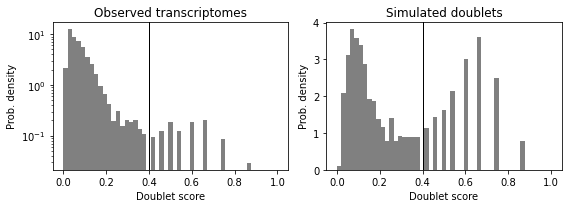

In [52]:
# BL42 - control
scrub = scr.Scrublet(adata_BL42.X)

doublet_scores, predicted_doublets = scrub.scrub_doublets(synthetic_doublet_umi_subsampling=1, n_prin_comps=30, log_transform=False)

# Mine
scrub.plot_histogram()

In [53]:
sum(predicted_doublets)

107

In [54]:
adata_BL42.obs['doublet_scores'] = doublet_scores
adata_BL42.obs['predicted_doublets'] = predicted_doublets

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [55]:
adata_BL42.obs.head()

,library_name,batch,doublet_scores,predicted_doublets
AAACCCAAGATCCAAA-2,BL42_control,experiment,0.066955,False
AAACCCAAGCAGCCTC-2,BL42_control,experiment,0.056380,False
AAACCCAAGCCTATTG-2,BL42_control,experiment,0.538462,True
AAACCCAAGCGTTCAT-2,BL42_control,experiment,0.030769,False
AAACCCAAGTCACAGG-2,BL42_control,experiment,0.069307,False


In [56]:
adata_BL42.obs['predicted_doublets'].sum()

107

# 2 Save results

In [62]:
df_annot = pd.concat((adata_BL41.obs, adata_BL42.obs, adata_10X_sample11.obs, adata_10X_sample51.obs))

In [63]:
df_annot.shape

(33145, 4)

In [64]:
adata.shape

(33145, 31055)

In [65]:
df_annot.to_csv('df_annot.csv')